<a href="https://colab.research.google.com/github/ashmeenkhaira/Crop-cycle-shift-using-Remote-sensing-data/blob/main/Copy_of_wheat_88_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import warnings
import random
import tensorflow as tf

# Set random seeds for reproducibility
seed_value = 42
np.random.seed(seed_value)
random.seed(seed_value)
tf.random.set_seed(seed_value)

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [2]:
ndvi_file_path = "/content/Patiala_Weekly_NDVI_2019_2024.csv"
weather_file_path = "/content/Patiala_Weekly_Climate_2019_2024.csv"
ndvi_data = pd.read_csv(ndvi_file_path)
print(f"NDVI data shape: {ndvi_data.shape}")
print(f"NDVI columns: {ndvi_data.columns.tolist()}")
weather_data = pd.read_csv(weather_file_path)
print(f"Weather data shape: {weather_data.shape}")
print(f"Weather columns: {weather_data.columns.tolist()}")

NDVI data shape: (313, 4)
NDVI columns: ['system:index', 'ndvi_mean', 'week_start', '.geo']
Weather data shape: (313, 5)
Weather columns: ['system:index', 'rainfall_mm', 'temp_C', 'week_start', '.geo']


In [3]:
#data preprocessing
# Convert week_start columns to datetime
ndvi_data['week_start'] = pd.to_datetime(ndvi_data['week_start'], format='%Y-%m-%d')
weather_data['week_start'] = pd.to_datetime(weather_data['week_start'], format='%Y-%m-%d')

print(f"NDVI date range: {ndvi_data['week_start'].min()} to {ndvi_data['week_start'].max()}")
print(f"Weather date range: {weather_data['week_start'].min()} to {weather_data['week_start'].max()}")

merged_data = pd.merge(ndvi_data, weather_data, on='week_start', how='inner', suffixes=('_ndvi', '_weather'))
merged_data.set_index('week_start', inplace=True)
merged_data = merged_data.sort_index()

print(f"Merged data shape: {merged_data.shape}")
print(f"Final date range: {merged_data.index.min()} to {merged_data.index.max()}")
print(f"Total weeks of data: {len(merged_data)}")
print("\nSample of merged data:")
print(merged_data.head())
print(f"\nColumn names: {merged_data.columns.tolist()}")

#STEP 3: FEATURE ENGINEERING
data = merged_data.copy()
data['ndvi_ma4'] = data['ndvi_mean'].rolling(window=4, min_periods=1).mean()
data['ndvi_ma8'] = data['ndvi_mean'].rolling(window=8, min_periods=1).mean()
data['ndvi_ma12'] = data['ndvi_mean'].rolling(window=12, min_periods=1).mean()
data['ndvi_change'] = data['ndvi_mean'].diff()
data['ndvi_change_rate'] = data['ndvi_mean'].pct_change()
data['ndvi_std4'] = data['ndvi_mean'].rolling(window=4, min_periods=1).std()


NDVI date range: 2019-01-01 00:00:00 to 2024-12-24 00:00:00
Weather date range: 2019-01-01 00:00:00 to 2024-12-24 00:00:00
Merged data shape: (313, 7)
Final date range: 2019-01-01 00:00:00 to 2024-12-24 00:00:00
Total weeks of data: 313

Sample of merged data:
            system:index_ndvi  ndvi_mean  \
week_start                                 
2019-01-01                  0   0.523874   
2019-01-08                  1   0.668739   
2019-01-15                  2        NaN   
2019-01-22                  3   0.724466   
2019-01-29                  4   0.707964   

                                         .geo_ndvi  system:index_weather  \
week_start                                                                 
2019-01-01  {"type":"MultiPoint","coordinates":[]}                     0   
2019-01-08  {"type":"MultiPoint","coordinates":[]}                     1   
2019-01-15  {"type":"MultiPoint","coordinates":[]}                     2   
2019-01-22  {"type":"MultiPoint","coordinates":[]}

In [4]:
data['ndvi_change_rate'] = data['ndvi_change_rate'].replace([np.inf, -np.inf], np.nan)

# Vegetation vigor indicators
data['ndvi_above_ma8'] = (data['ndvi_mean'] > data['ndvi_ma8']).astype(int)
data['ndvi_peak_detection'] = ((data['ndvi_mean'] > data['ndvi_ma8']) & (data['ndvi_change'] > 0)).astype(int)
data['ndvi_decline_detection'] = ((data['ndvi_mean'] < data['ndvi_ma8']) & (data['ndvi_change'] < 0)).astype(int)
data['ndvi_normalized'] = (data['ndvi_mean'] - data['ndvi_mean'].min()) / (data['ndvi_mean'].max() - data['ndvi_mean'].min())
data['rainfall_ma4'] = data['rainfall_mm'].rolling(window=4, min_periods=1).mean()
data['rainfall_ma8'] = data['rainfall_mm'].rolling(window=8, min_periods=1).mean()
data['rainfall_cumulative_12w'] = data['rainfall_mm'].rolling(window=12, min_periods=1).sum()
data['rainfall_cumulative_4w'] = data['rainfall_mm'].rolling(window=4, min_periods=1).sum()
data['rainfall_intensity'] = data['rainfall_mm'].rolling(window=4, min_periods=1).std()
data['dry_period'] = (data['rainfall_mm'] < data['rainfall_mm'].quantile(0.25)).astype(int)
data['wet_period'] = (data['rainfall_mm'] > data['rainfall_mm'].quantile(0.75)).astype(int)

data['temp_ma4'] = data['temp_C'].rolling(window=4, min_periods=1).mean()
data['temp_ma8'] = data['temp_C'].rolling(window=8, min_periods=1).mean()
data['temp_range_4w'] = data['temp_C'].rolling(window=4, min_periods=1).max() - data['temp_C'].rolling(window=4, min_periods=1).min()
data['temp_std4'] = data['temp_C'].rolling(window=4, min_periods=1).std()


In [5]:
data['gdd_wheat'] = np.maximum(data['temp_C'] - 10, 0)  # Base 10°C for wheat
data['gdd_paddy'] = np.maximum(data['temp_C'] - 15, 0)  # Base 15°C for paddy
data['gdd_wheat_cumulative'] = data['gdd_wheat'].rolling(window=12, min_periods=1).sum()
data['gdd_paddy_cumulative'] = data['gdd_paddy'].rolling(window=12, min_periods=1).sum()
data['heat_stress'] = (data['temp_C'] > data['temp_C'].quantile(0.9)).astype(int)
data['cold_stress'] = (data['temp_C'] < data['temp_C'].quantile(0.1)).astype(int)
data['week_of_year'] = data.index.isocalendar().week
data['month'] = data.index.month
data['quarter'] = data.index.quarter
data['day_of_year'] = data.index.dayofyear

In [6]:
data['week_sin'] = np.sin(2 * np.pi * data['week_of_year'] / 52)
data['week_cos'] = np.cos(2 * np.pi * data['week_of_year'] / 52)
data['month_sin'] = np.sin(2 * np.pi * data['month'] / 12)
data['month_cos'] = np.cos(2 * np.pi * data['month'] / 12)
data['wheat_season'] = ((data['month'] >= 11) | (data['month'] <= 4)).astype(int)
data['paddy_season'] = ((data['month'] >= 5) & (data['month'] <= 10)).astype(int)
data['monsoon_season'] = ((data['month'] >= 6) & (data['month'] <= 9)).astype(int)
data['winter_season'] = ((data['month'] >= 12) | (data['month'] <= 2)).astype(int)
data = data.fillna(method='ffill').fillna(method='bfill')

print(f"Data shape after feature engineering: {data.shape}")
new_features = len([col for col in data.columns if any(suffix in col for suffix in ['_ma', '_cumulative', '_gdd', '_sin', '_cos', '_season', '_stress', '_period', '_detection', '_change', '_rate', '_normalized', '_above', '_std'])])
print(f"Created {new_features} new features")

Data shape after feature engineering: (313, 46)
Created 31 new features


In [7]:
# STEP 4: CREATE CROP STAGE LABELS
data['wheat_stage'] = 0  # 0: fallow, 1: sowing, 2: growing, 3: harvesting
data['paddy_stage'] = 0
wheat_mask = data['wheat_season'] == 1
if wheat_mask.sum() > 0:
    wheat_data = data[wheat_mask]
    sowing_condition = (wheat_data['ndvi_mean'] > wheat_data['ndvi_mean'].quantile(0.2)) & \
                      (wheat_data['ndvi_change'] > 0) & \
                      (wheat_data['month'].isin([11, 12]))

    growing_condition = (wheat_data['ndvi_mean'] > wheat_data['ndvi_mean'].quantile(0.6)) & \
                       (wheat_data['month'].isin([1, 2, 3]))

    harvesting_condition = (wheat_data['ndvi_mean'] > wheat_data['ndvi_mean'].quantile(0.4)) & \
                          (wheat_data['ndvi_change'] < 0) & \
                          (wheat_data['month'].isin([3, 4]))
    data.loc[wheat_mask & sowing_condition, 'wheat_stage'] = 1
    data.loc[wheat_mask & growing_condition, 'wheat_stage'] = 2
    data.loc[wheat_mask & harvesting_condition, 'wheat_stage'] = 3

# Paddy crop cycle (May-Oct in Punjab)
paddy_mask = data['paddy_season'] == 1
if paddy_mask.sum() > 0:
    paddy_data = data[paddy_mask]
    sowing_condition = (paddy_data['ndvi_mean'] > paddy_data['ndvi_mean'].quantile(0.2)) & \
                      (paddy_data['ndvi_change'] > 0) & \
                      (paddy_data['month'].isin([5, 6]))

    growing_condition = (paddy_data['ndvi_mean'] > paddy_data['ndvi_mean'].quantile(0.6)) & \
                       (paddy_data['month'].isin([7, 8, 9]))

    harvesting_condition = (paddy_data['ndvi_mean'] > paddy_data['ndvi_mean'].quantile(0.4)) & \
                          (paddy_data['ndvi_change'] < 0) & \
                          (paddy_data['month'].isin([9, 10]))

    data.loc[paddy_mask & sowing_condition, 'paddy_stage'] = 1
    data.loc[paddy_mask & growing_condition, 'paddy_stage'] = 2
    data.loc[paddy_mask & harvesting_condition, 'paddy_stage'] = 3

print(f"Wheat stage distribution: {data['wheat_stage'].value_counts().sort_index()}")
print(f"Paddy stage distribution: {data['paddy_stage'].value_counts().sort_index()}")


Wheat stage distribution: wheat_stage
0    217
1     30
2     44
3     22
Name: count, dtype: int64
Paddy stage distribution: paddy_stage
0    222
1     15
2     40
3     36
Name: count, dtype: int64


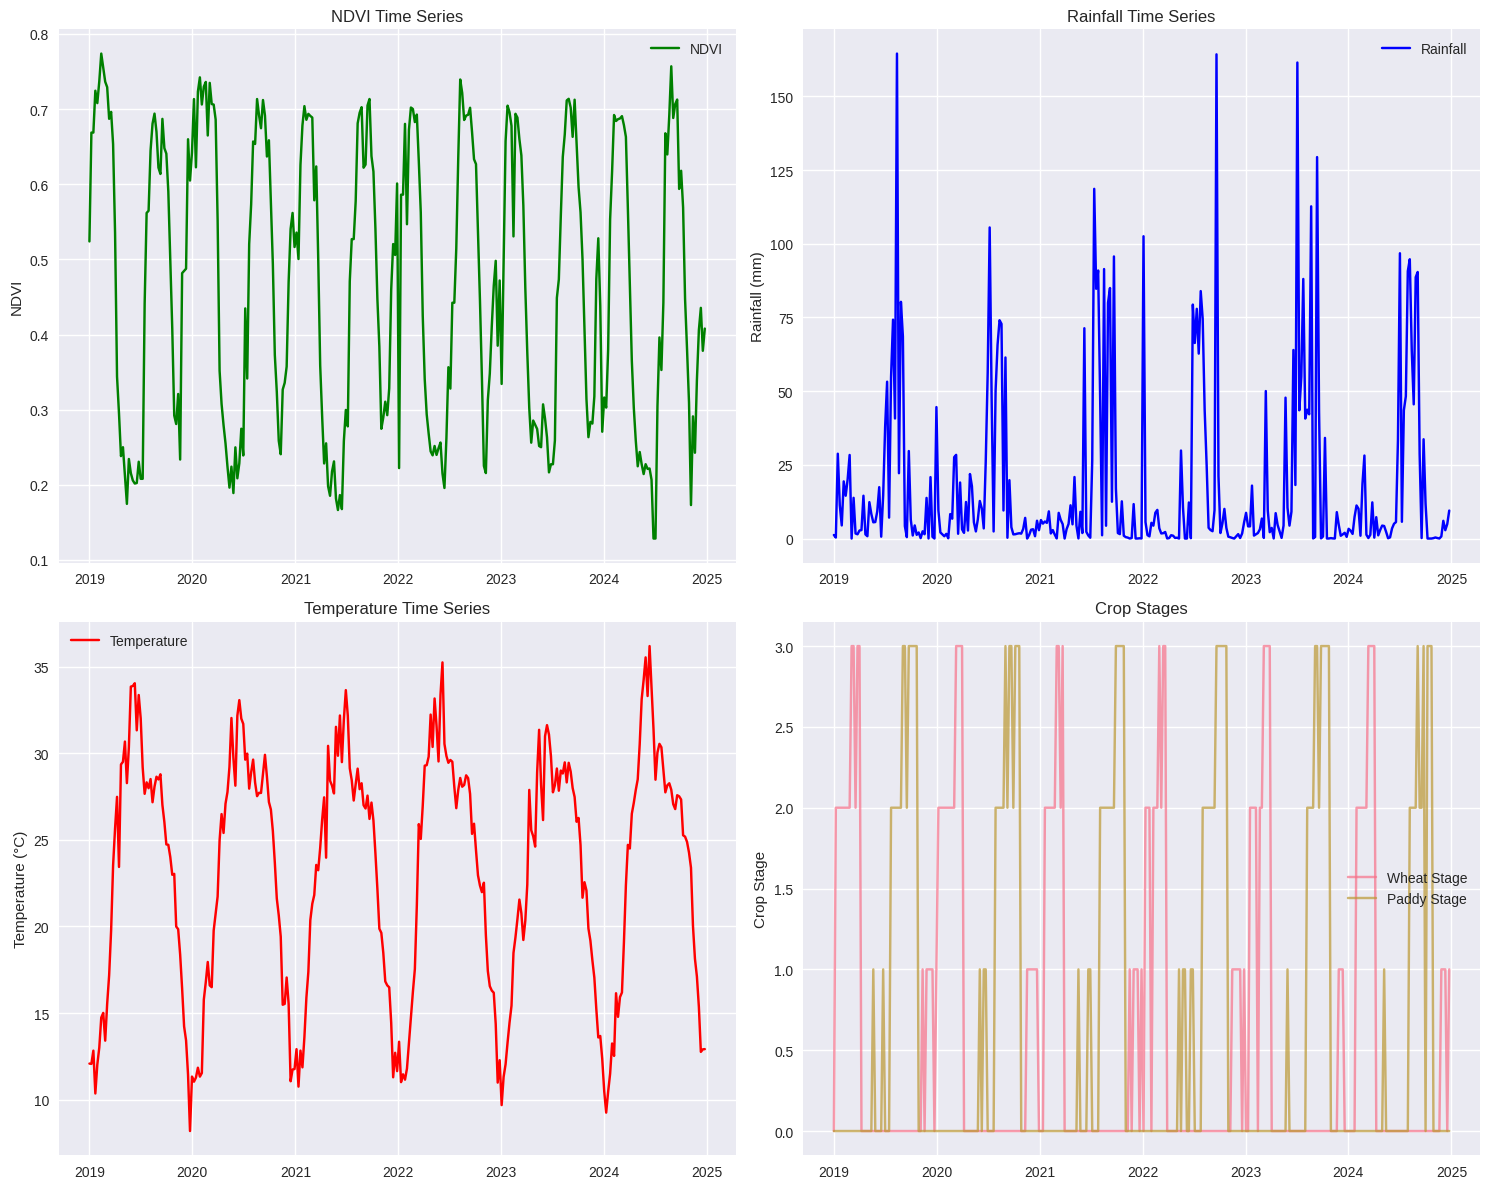

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# NDVI time series
axes[0, 0].plot(data.index, data['ndvi_mean'], label='NDVI', color='green')
axes[0, 0].set_title('NDVI Time Series')
axes[0, 0].set_ylabel('NDVI')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Rainfall time series
axes[0, 1].plot(data.index, data['rainfall_mm'], label='Rainfall', color='blue')
axes[0, 1].set_title('Rainfall Time Series')
axes[0, 1].set_ylabel('Rainfall (mm)')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Temperature time series
axes[1, 0].plot(data.index, data['temp_C'], label='Temperature', color='red')
axes[1, 0].set_title('Temperature Time Series')
axes[1, 0].set_ylabel('Temperature (°C)')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Crop stages
axes[1, 1].plot(data.index, data['wheat_stage'], label='Wheat Stage', alpha=0.7)
axes[1, 1].plot(data.index, data['paddy_stage'], label='Paddy Stage', alpha=0.7)
axes[1, 1].set_title('Crop Stages')
axes[1, 1].set_ylabel('Crop Stage')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

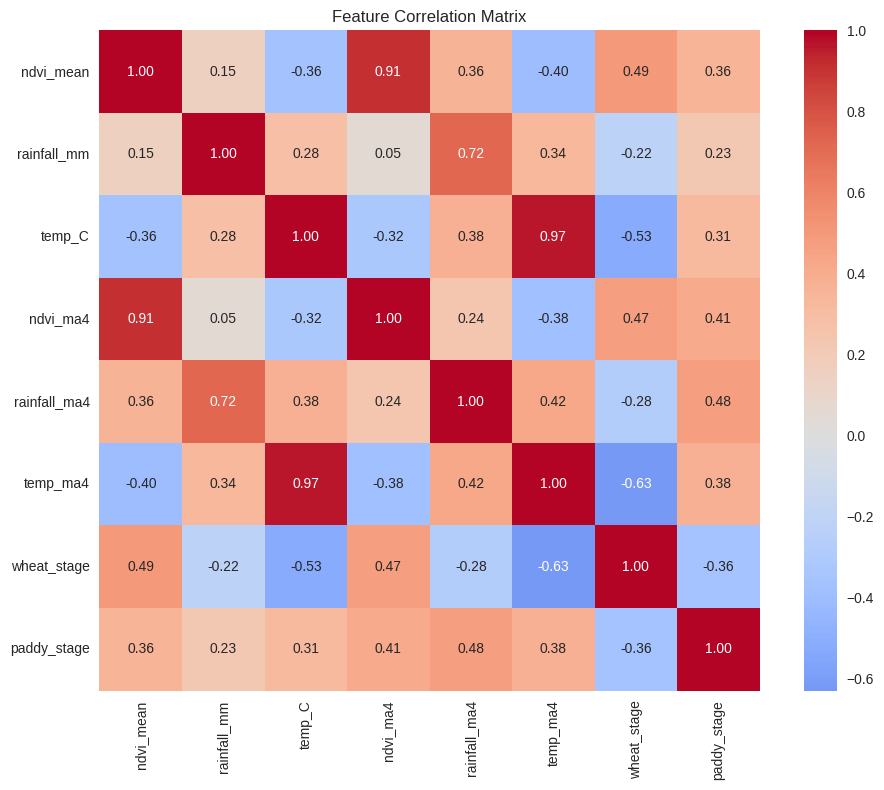

In [9]:
# Correlation heatmap for key features
key_features = ['ndvi_mean', 'rainfall_mm', 'temp_C', 'ndvi_ma4', 'rainfall_ma4', 'temp_ma4', 'wheat_stage', 'paddy_stage']
correlation_matrix = data[key_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f', square=True)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

In [10]:
target_crop = 'wheat'
print(f"Preparing data for {target_crop} prediction")
feature_columns = []
ndvi_features = [col for col in data.columns if 'ndvi' in col.lower() and 'detection' not in col.lower() and '.geo' not in col.lower()]
feature_columns.extend(ndvi_features)
weather_features = [col for col in data.columns if any(x in col.lower() for x in ['rain', 'temp', 'degree']) and '.geo' not in col.lower()]
feature_columns.extend(weather_features)
seasonal_features = [col for col in data.columns if col in ['week_of_year', 'month', 'quarter', 'day_of_year', 'week_sin', 'week_cos', 'month_sin', 'month_cos']]
feature_columns.extend(seasonal_features)
season_features = [col for col in data.columns if any(x in col for x in ['wheat_season', 'paddy_season', 'monsoon_season', 'winter_season'])]
feature_columns.extend(season_features)
indicator_features = [col for col in data.columns if any(x in col.lower() for x in ['stress', 'period', 'above']) and 'stage' not in col.lower()]
feature_columns.extend(indicator_features)

Preparing data for wheat prediction


In [11]:
exclude_cols = ['.geo_ndvi', '.geo_weather', 'system:index_ndvi', 'system:index_weather']
feature_columns = [col for col in feature_columns if col not in exclude_cols]
feature_columns = sorted(list(set(feature_columns)))
target_column = f'{target_crop}_stage'

print(f"Selected features ({len(feature_columns)}): {feature_columns}")
print(f"Target: {target_column}")
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(data[feature_columns])
y_scaled = scaler_y.fit_transform(data[[target_column]])
scaled_data = pd.DataFrame(X_scaled, columns=feature_columns, index=data.index)
scaled_data[target_column] = y_scaled

Selected features (36): ['cold_stress', 'day_of_year', 'dry_period', 'heat_stress', 'monsoon_season', 'month', 'month_cos', 'month_sin', 'ndvi_above_ma8', 'ndvi_change', 'ndvi_change_rate', 'ndvi_ma12', 'ndvi_ma4', 'ndvi_ma8', 'ndvi_mean', 'ndvi_normalized', 'ndvi_std4', 'paddy_season', 'quarter', 'rainfall_cumulative_12w', 'rainfall_cumulative_4w', 'rainfall_intensity', 'rainfall_ma4', 'rainfall_ma8', 'rainfall_mm', 'temp_C', 'temp_ma4', 'temp_ma8', 'temp_range_4w', 'temp_std4', 'week_cos', 'week_of_year', 'week_sin', 'wet_period', 'wheat_season', 'winter_season']
Target: wheat_stage


In [12]:
sequence_length = 12
print(f"Creating sequences with length: {sequence_length}")

X, y = [], []
for i in range(sequence_length, len(scaled_data)):
    X.append(scaled_data[feature_columns].iloc[i-sequence_length:i].values)
    y.append(scaled_data[target_column].iloc[i])

X, y = np.array(X), np.array(y)
print(f"Sequence shape: X={X.shape}, y={y.shape}")

Creating sequences with length: 12
Sequence shape: X=(301, 12, 36), y=(301,)


In [13]:
# Fix the random state for reproducible data splitting
# fixed_random_state = 130
# print(f"Using fixed random_state = {fixed_random_state} for data splitting")

# X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=fixed_random_state)
# X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=fixed_random_state)

# Perform temporal split
train_size = int(len(X) * 0.7)
val_size = int(len(X) * 0.15)
test_size = len(X) - train_size - val_size

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
X_test, y_test = X[train_size + val_size:], y[train_size + val_size:]

print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")

Training set: (210, 12, 36)
Validation set: (45, 12, 36)
Test set: (46, 12, 36)


In [14]:
input_shape = (sequence_length, len(feature_columns))
print(f"Building LSTM model with input shape: {input_shape}")

model = Sequential([
    LSTM(50, return_sequences=True, input_shape=input_shape),
    Dropout(0.2),
    LSTM(50, return_sequences=True),
    Dropout(0.2),
    LSTM(25, return_sequences=False),
    Dropout(0.2),
    Dense(25, activation='relu'),
    Dense(1, activation='linear')
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
print("Model architecture:")
model.summary()

Building LSTM model with input shape: (12, 36)
Model architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 12, 50)         │        17,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 12, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 25)             │         7,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 25)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │           650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 45,876 (179.20 KB)

 Trainable params: 45,876 (179.20 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
epochs = 100
batch_size = 32
print(f"Training LSTM model for {epochs} epochs...")
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=0.0001)
history = model.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Training LSTM model for 100 epochs...
Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - loss: 1.0553 - mae: 0.8642 - val_loss: 0.3916 - val_mae: 0.5841 - learning_rate: 0.0010
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.6701 - mae: 0.6766 - val_loss: 0.4746 - val_mae: 0.5166 - learning_rate: 0.0010
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.4409 - mae: 0.4880 - val_loss: 0.4010 - val_mae: 0.3874 - learning_rate: 0.0010
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.3432 - mae: 0.3771 - val_loss: 0.2486 - val_mae: 0.2988 - learning_rate: 0.0010
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.3455 - mae: 0.3731 - val_loss: 0.1502 - val_mae: 0.2366 - learning_rate: 0.0010
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.3009 - mae: 0.3524 - val_loss: 0.2459 - val_mae: 0.2658 - learning_rate: 0.0010
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.2484 - mae: 0.3134 - val_loss: 0.1926 - val_mae: 0.2413 - lear

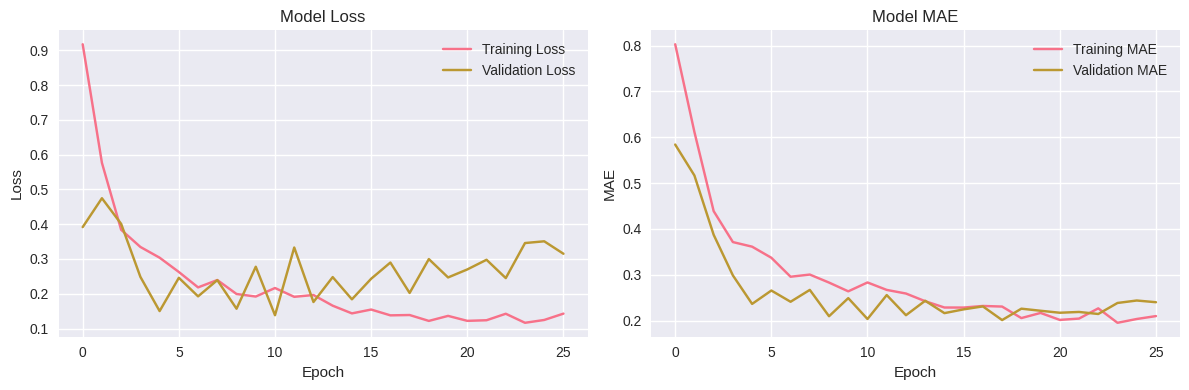

In [16]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
Mean Squared Error: 0.0995
Mean Absolute Error: 0.1577
R-squared Score: 0.8947


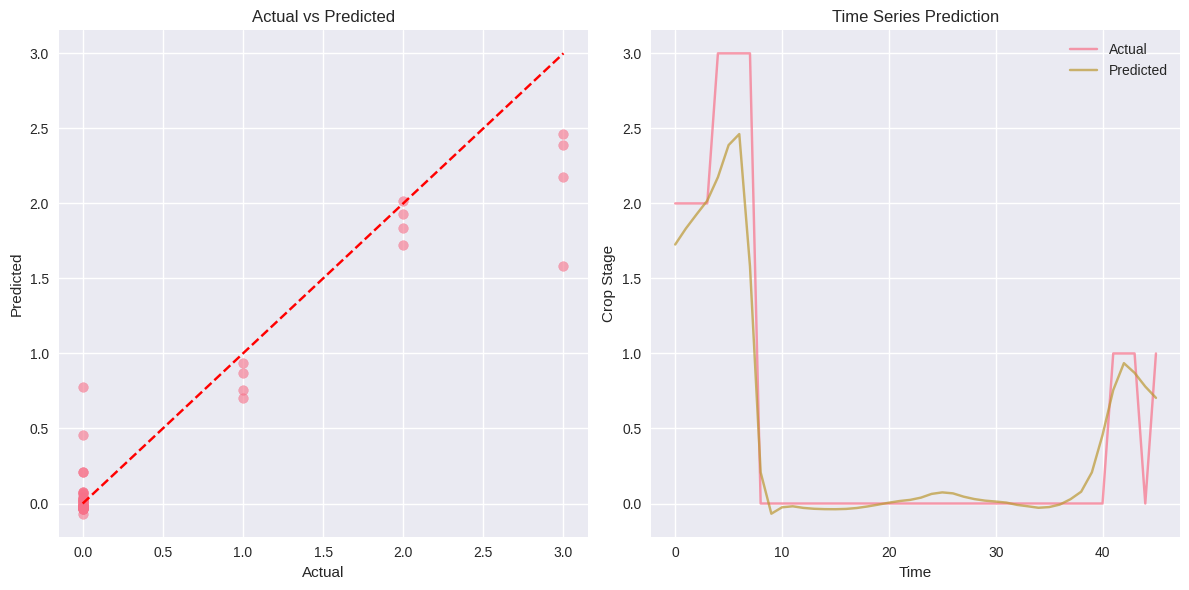

In [17]:
# Make predictions
y_pred = model.predict(X_test)
y_test_original = scaler_y.inverse_transform(y_test.reshape(-1, 1))
y_pred_original = scaler_y.inverse_transform(y_pred)
mse = mean_squared_error(y_test_original, y_pred_original)
mae = mean_absolute_error(y_test_original, y_pred_original)
r2 = r2_score(y_test_original, y_pred_original)

print(f"Mean Squared Error: {mse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"R-squared Score: {r2:.4f}")

# Visualization
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_test_original, y_pred_original, alpha=0.6)
plt.plot([y_test_original.min(), y_test_original.max()], [y_test_original.min(), y_test_original.max()], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(y_test_original, label='Actual', alpha=0.7)
plt.plot(y_pred_original, label='Predicted', alpha=0.7)
plt.xlabel('Time')
plt.ylabel('Crop Stage')
plt.title('Time Series Prediction')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [39]:
X_scaled_full = scaler_X.transform(data[feature_columns])
X_sequences = []
for i in range(sequence_length, len(X_scaled_full)):
    X_sequences.append(X_scaled_full[i-sequence_length:i])
X_sequences = np.array(X_sequences)
predictions = model.predict(X_sequences)
predictions_original = scaler_y.inverse_transform(predictions)

results = pd.DataFrame({
    'predicted_stage': predictions_original.flatten()
}, index=data.index[sequence_length:])

results['stage_change'] = results['predicted_stage'].diff()
results['sowing_signal'] = (results['stage_change'] > 0.27).astype(int)
results['harvesting_signal'] = (results['stage_change'] < -0.5).astype(int)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Prediction Summary:
Sowing signals detected: 6
Harvesting signals detected: 11


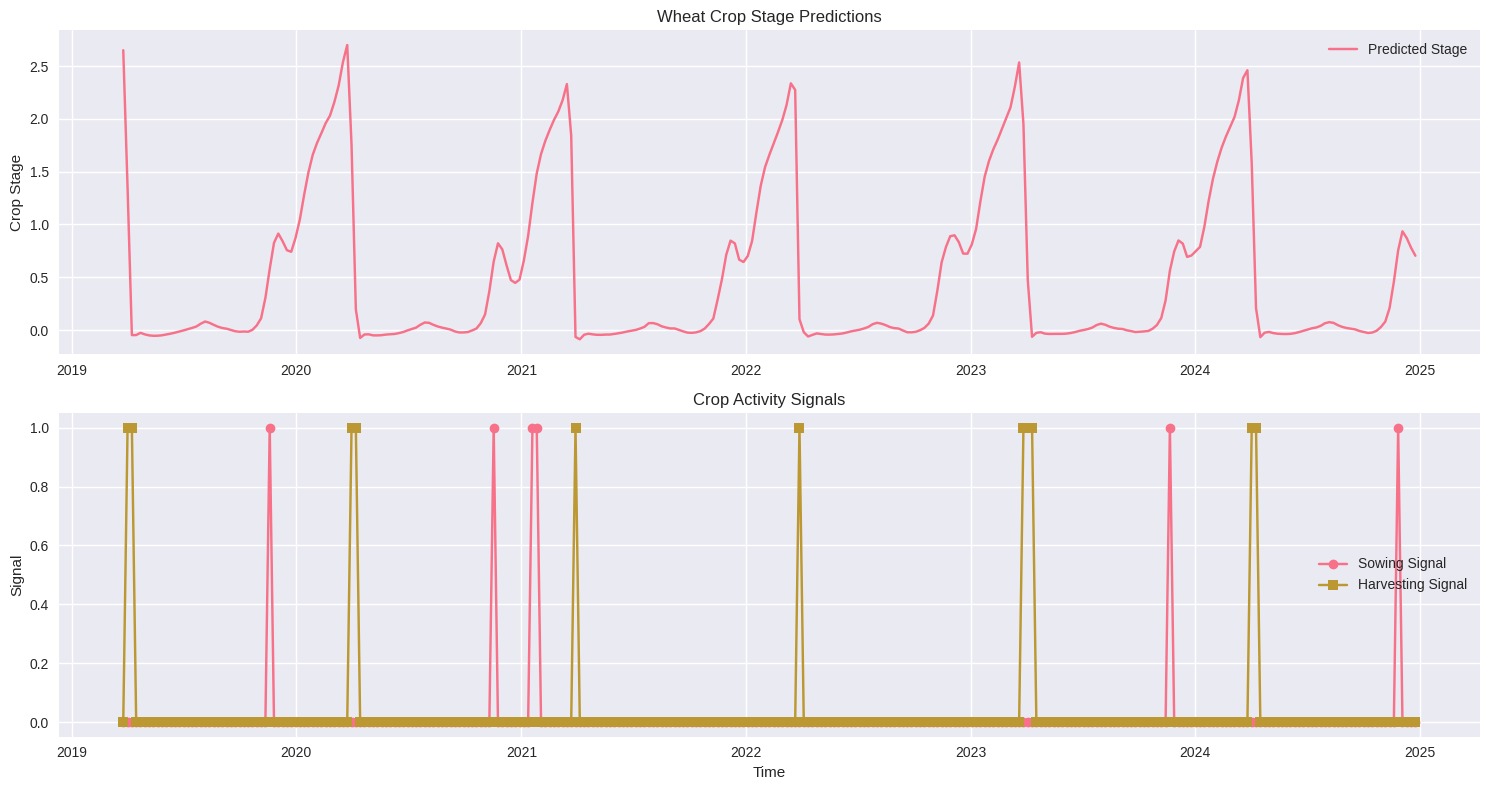

In [40]:
print("Prediction Summary:")
print(f"Sowing signals detected: {results['sowing_signal'].sum()}")
print(f"Harvesting signals detected: {results['harvesting_signal'].sum()}")

# Plot predictions
plt.figure(figsize=(15, 8))
plt.subplot(2, 1, 1)
plt.plot(results.index, results['predicted_stage'], label='Predicted Stage')
plt.ylabel('Crop Stage')
plt.title(f'{target_crop.capitalize()} Crop Stage Predictions')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(results.index, results['sowing_signal'], label='Sowing Signal', marker='o')
plt.plot(results.index, results['harvesting_signal'], label='Harvesting Signal', marker='s')
plt.ylabel('Signal')
plt.xlabel('Time')
plt.title('Crop Activity Signals')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [41]:
# Save predictions
results.to_csv('wheat_predictions.csv')
print("Wheat predictions saved to 'wheat_predictions.csv'")

Wheat predictions saved to 'wheat_predictions.csv'


In [21]:
from datetime import datetime, timedelta
import pandas as pd
import numpy as np

def input_year(operation_type):
    year1 = int(input(f"Enter first year for {operation_type} comparison: "))
    year2 = int(input(f"Enter second year for {operation_type} comparison: "))
    return year1, year2

def harvesting_periods(df, stage_col='predicted_stage', signal_col='harvesting_signal'):
    harvesting_periods = []
    # Consider both the specific harvesting signal and a significant drop in predicted stage
    harvest_signals = df[df[signal_col] == 1].copy()
    # Adjusted threshold for stage transitions
    stage_transitions = df[df[stage_col].diff() < -0.3].copy() # Look for drops in stage value

    # Combine signals and transitions, keep unique entries and sort by date
    all_harvest_data = pd.concat([harvest_signals, stage_transitions]).drop_duplicates().sort_index()

    for date in all_harvest_data.index:
        month = date.month
        # Consider April and May for wheat harvesting in Punjab
        if month in [4, 5] and date in df.index:
            harvesting_periods.append({
                'date': date,
                'year': date.year,
                'month': date.month,
                'week': date.isocalendar()[1],
                'day_of_year': date.timetuple().tm_yday,
                'stage_value': df.loc[date, stage_col],
                'signal_value': df.loc[date, signal_col] # This will be 1 for signal, NaN or 0 for stage transition
            })

    return pd.DataFrame(harvesting_periods)

def sowing_periods(df, stage_col='predicted_stage', signal_col='sowing_signal'):
    sowing_periods = []
    # Consider both the specific sowing signal and a significant increase in predicted stage
    sow_signals = df[df[signal_col] == 1].copy()
    # Adjusted threshold for stage transitions
    stage_transitions = df[df[stage_col].diff() > 0.3].copy() # Look for increases in stage value

    # Combine signals and transitions, keep unique entries and sort by date
    all_sow_data = pd.concat([sow_signals, stage_transitions]).drop_duplicates().sort_index()

    for date in all_sow_data.index:
        month = date.month
        # Consider November and December for wheat sowing in Punjab
        if month in [11, 12] and date in df.index:
            sowing_periods.append({
                'date': date,
                'year': date.year,
                'month': date.month,
                'week': date.isocalendar()[1],
                'day_of_year': date.timetuple().tm_yday,
                'stage_value': df.loc[date, stage_col],
                'signal_value': df.loc[date, signal_col] # This will be 1 for signal, NaN or 0 for stage transition
            })

    return pd.DataFrame(sowing_periods)

def year_comparison(df, year1, year2, operation_type):
    # Filter data for both years
    year1_data = df[df['year'] == year1]
    year2_data = df[df['year'] == year2]

    # Check if data exists for both years
    if len(year1_data) == 0:
        print(f"No {operation_type} data found for year {year1}")
        return None

    if len(year2_data) == 0:
        print(f"No {operation_type} data found for year {year2}")
        return None

    # Get the best entry for each year (first occurrence in the defined months)
    # We sort by date to get the earliest occurrence within the target months
    year1_entry = year1_data.sort_values(by='date').iloc[0]
    year2_entry = year2_data.sort_values(by='date').iloc[0]

    # Calculate shifts
    total_day_shift = year2_entry['day_of_year'] - year1_entry['day_of_year']
    total_week_shift = year2_entry['week'] - year1_entry['week']
    years_span = year2 - year1
    avg_day_shift_per_year = total_day_shift / years_span if years_span != 0 else 0
    avg_week_shift_per_year = total_week_shift / years_span if years_span != 0 else 0


    if total_day_shift > 0:
        shift_direction = "Later"
    elif total_day_shift < 0:
        shift_direction = "Earlier"
    else:
        shift_direction = "Same"

    return {
        'from_year': year1,
        'to_year': year2,
        'year1_data': year1_entry,
        'year2_data': year2_entry,
        'year1_date': year1_entry['date'],
        'year2_date': year2_entry['date'],
        'total_day_shift': total_day_shift,
        'total_week_shift': total_week_shift,
        'avg_day_shift_per_year': avg_day_shift_per_year,
        'avg_week_shift_per_year': avg_week_shift_per_year,
        'shift_direction': shift_direction,
        'shift_magnitude': abs(total_day_shift)
    }

def comparison_results(comparison, operation_type):
    print(f"\n{operation_type.title()} Analysis: {comparison['from_year']} to {comparison['to_year']}")
    print(f"  {int(comparison['year1_data']['year'])}: {comparison['year1_date'].strftime('%Y-%m-%d')} (Day {int(comparison['year1_data']['day_of_year'])}) (Stage: {comparison['year1_data']['stage_value']:.2f}, Signal: {comparison['year1_data']['signal_value']})")
    print(f"  {int(comparison['year2_data']['year'])}: {comparison['year2_date'].strftime('%Y-%m-%d')} (Day {int(comparison['year2_data']['day_of_year'])}) (Stage: {comparison['year2_data']['stage_value']:.2f}, Signal: {comparison['year2_data']['signal_value']})")
    print(f"Total shift: {comparison['total_day_shift']:+.1f} days ({comparison['shift_direction']})")
    print(f"Average: {comparison['avg_day_shift_per_year']:+.1f} days/year")

def get_fallback_data(results, months, operation_type):
    """Get fallback data when no specific signals are detected within the main function"""
    target_months = results[results.index.month.isin(months)].copy()
    target_months['year'] = target_months.index.year

    yearly_data = []
    for year in target_months['year'].unique():
        year_data = target_months[target_months['year'] == year]
        if len(year_data) > 0:
            # Fallback logic: Find the date closest to the target stage (3 for harvesting, 1 for sowing)
            target_stage = 3 if operation_type == "harvesting" else 1
            closest_date_idx = (year_data['predicted_stage'] - target_stage).abs().idxmin()

            if closest_date_idx is not None and closest_date_idx in year_data.index:
                yearly_data.append({
                    'date': closest_date_idx,
                    'year': year,
                    'month': closest_date_idx.month,
                    'week': closest_date_idx.isocalendar()[1],
                    'day_of_year': closest_date_idx.timetuple().tm_yday,
                    'stage_value': year_data.loc[closest_date_idx, 'predicted_stage'],
                    'signal_value': year_data.loc[closest_date_idx, f'{operation_type}_signal'] # This might be 0 or NaN in fallback
                })

    # Sort by date to ensure consistent picking for comparison
    return pd.DataFrame(yearly_data).sort_values(by='date')

def analyze_harvesting_shifts(results):
    harvesting_df = harvesting_periods(results)

    # If no specific harvesting periods detected, use fallback method
    if len(harvesting_df) == 0:
        print("No specific harvesting signals detected. Using fallback method to find dates closest to stage 3 in April-May...")
        harvesting_df = get_fallback_data(results, [4, 5], "harvesting")

    if len(harvesting_df) == 0:
        print("No wheat harvesting periods detected in the data.")
        return

    available_years = sorted(harvesting_df['year'].unique())
    print(f"Available years for wheat harvesting data: {available_years}")

    # Show sample of available data, including all years in April-May for context
    print("\nHarvesting data points (April-May):")
    april_may_data = results[results.index.month.isin([4, 5])].copy()
    april_may_data['year'] = april_may_data.index.year
    print(april_may_data[['predicted_stage', 'harvesting_signal', 'stage_change']].head())
    print(april_may_data[['predicted_stage', 'harvesting_signal', 'stage_change']].tail())

    year1, year2 = input_year("wheat harvesting")

    # Validate year inputs
    if year1 not in available_years:
        print(f"Year {year1} not available in the detected harvesting periods. Available years: {available_years}")
        print("Note: This analysis compares specific detected periods. If you need to compare years where no specific signal was detected, the fallback method is used, but the year must still be present in the April-May data range.")
        return
    if year2 not in available_years:
        print(f"Year {year2} not available in the detected harvesting periods. Available years: {available_years}")
        print("Note: This analysis compares specific detected periods. If you need to compare years where no specific signal was detected, the fallback method is used, but the year must still be present in the April-May data range.")
        return

    comparison = year_comparison(harvesting_df, year1, year2, "wheat harvesting")

    if comparison is None:
        return

    comparison_results(comparison, "wheat harvesting")
    return comparison


def analyze_sowing_shifts(results):
    sowing_df = sowing_periods(results)

    # If no specific sowing periods detected, use fallback method
    if len(sowing_df) == 0:
        print("No specific sowing signals detected. Using fallback method to find dates closest to stage 1 in November-December...")
        sowing_df = get_fallback_data(results, [11, 12], "sowing")

    if len(sowing_df) == 0:
        print("No wheat sowing periods detected in the data.")
        return

    available_years = sorted(sowing_df['year'].unique())
    print(f"Available years for wheat sowing data: {available_years}")

    # Show sample of available data, including all years in Nov-Dec for context
    print("\nSowing data points (November-December):")
    nov_dec_data = results[results.index.month.isin([11, 12])].copy()
    nov_dec_data['year'] = nov_dec_data.index.year
    print(nov_dec_data[['predicted_stage', 'sowing_signal', 'stage_change']].head())
    print(nov_dec_data[['predicted_stage', 'sowing_signal', 'stage_change']].tail())

    year1, year2 = input_year("wheat sowing")

    # Validate year inputs
    if year1 not in available_years:
        print(f"Year {year1} not available in the detected sowing periods. Available years: {available_years}")
        print("Note: This analysis compares specific detected periods. If you need to compare years where no specific signal was detected, the fallback method is used, but the year must still be present in the November-December data range.")
        return
    if year2 not in available_years:
        print(f"Year {year2} not available in the detected sowing periods. Available years: {available_years}")
        print("Note: This analysis compares specific detected periods. If you need to compare years where no specific signal was detected, the fallback method is used, but the year must still be present in the November-December data range.")
        return

    comparison = year_comparison(sowing_df, year1, year2, "wheat sowing")

    if comparison is None:
        return

    comparison_results(comparison, "wheat sowing")
    return comparison

def debug_data_availability(results):
    """Debug function to check data availability"""
    print("=== DATA AVAILABILITY DEBUG ===")
    print(f"Total data points: {len(results)}")
    print(f"Date range: {results.index.min()} to {results.index.max()}")

    # Check years available
    years = results.index.year.unique()
    print(f"Years available in results DataFrame: {sorted(years)}")

    # Check for harvesting months (April-May)
    harvest_data = results[results.index.month.isin([4, 5])]
    harvest_years = harvest_data.index.year.unique()
    print(f"Years with April-May data: {sorted(harvest_years)}")
    print(f"Number of data points in April-May: {len(harvest_data)}")


    # Check for sowing months (November-December)
    sow_data = results[results.index.month.isin([11, 12])]
    sow_years = sow_data.index.year.unique()
    print(f"Years with November-December data: {sorted(sow_years)}")
    print(f"Number of data points in November-December: {len(sow_data)}")

    # Check signal columns
    if 'harvesting_signal' in results.columns:
        harvest_signals = results[results['harvesting_signal'] == 1]
        print(f"Harvesting signals (value=1) detected: {len(harvest_signals)}")
        if len(harvest_signals) > 0:
            print(f"Years with harvesting signals: {sorted(harvest_signals.index.year.unique())}")
            print("Sample harvesting signals:")
            print(harvest_signals.head())

    if 'sowing_signal' in results.columns:
        sow_signals = results[results['sowing_signal'] == 1]
        print(f"Sowing signals (value=1) detected: {len(sow_signals)}")
        if len(sow_signals) > 0:
            print(f"Years with sowing signals: {sorted(sow_signals.index.year.unique())}")
            print("Sample sowing signals:")
            print(sow_signals.head())

    # Check for significant stage drops (potential harvest) in April-May
    april_may_results = results[results.index.month.isin([4, 5])].copy()
    april_may_results['stage_change'] = april_may_results['predicted_stage'].diff()
    harvest_stage_drops = april_may_results[april_may_results['stage_change'] < -0.3]
    print(f"\nSignificant stage drops (potential harvest) in April-May (diff < -0.3): {len(harvest_stage_drops)}")
    if len(harvest_stage_drops) > 0:
        print("Sample stage drops:")
        print(harvest_stage_drops.head())
        print(f"Years with significant stage drops in April-May: {sorted(harvest_stage_drops.index.year.unique())}")

    # Check for significant stage increases (potential sowing) in Nov-Dec
    nov_dec_results = results[results.index.month.isin([11, 12])].copy()
    nov_dec_results['stage_change'] = nov_dec_results['predicted_stage'].diff()
    sow_stage_increases = nov_dec_results[nov_dec_results['stage_change'] > 0.3]
    print(f"\nSignificant stage increases (potential sowing) in Nov-Dec (diff > 0.3): {len(sow_stage_increases)}")
    if len(sow_stage_increases) > 0:
        print("Sample stage increases:")
        print(sow_stage_increases.head())
        print(f"Years with significant stage increases in Nov-Dec: {sorted(sow_stage_increases.index.year.unique())}")


    print("=== END DEBUG ===\n")


if __name__ == "__main__":
    # Add debug information
    if 'results' in globals():
        debug_data_availability(results)

    print("Choose analysis type:")
    print("1. Wheat harvesting shift analysis (April-May)")
    print("2. Wheat sowing shift analysis (November-December)")
    print("3. Debug data availability")

    choice = input("\nEnter your choice (1/2/3): ")

    if choice == '1':
        harvest_comparison = analyze_harvesting_shifts(results)
    elif choice == '2':
        sowing_comparison = analyze_sowing_shifts(results)
    elif choice == '3':
        if 'results' in globals():
            debug_data_availability(results)
        else:
            print("No 'results' variable found. Please ensure your data is loaded.")
    else:
        print("Invalid choice. Please run the script again.")

=== DATA AVAILABILITY DEBUG ===
Total data points: 301
Date range: 2019-03-26 00:00:00 to 2024-12-24 00:00:00
Years available in results DataFrame: [2019, 2020, 2021, 2022, 2023, 2024]
Years with April-May data: [2019, 2020, 2021, 2022, 2023, 2024]
Number of data points in April-May: 52
Years with November-December data: [2019, 2020, 2021, 2022, 2023, 2024]
Number of data points in November-December: 52
Harvesting signals (value=1) detected: 11
Years with harvesting signals: [2019, 2020, 2021, 2022, 2023, 2024]
Sample harvesting signals:
            predicted_stage  stage_change  sowing_signal  harvesting_signal
week_start                                                                 
2019-04-02         1.348112     -1.303554              0                  1
2019-04-09        -0.048157     -1.396269              0                  1
2020-03-31         1.755146     -0.945709              0                  1
2020-04-07         0.196483     -1.558664              0                  1


In [22]:
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

def input_year(operation_type):
    year1 = int(input(f"Enter first year for {operation_type} comparison: "))
    year2 = int(input(f"Enter second year for {operation_type} comparison: "))
    return year1, year2

def calculate_climate_metrics(df, start_date, end_date, operation_type):
    """Calculate climate metrics for a specific period"""
    # Ensure the DataFrame has a DatetimeIndex before slicing
    if not isinstance(df.index, pd.DatetimeIndex):
         # Check if 'week_start' column exists and convert it to datetime and set as index
        if 'week_start' in df.columns:
            df = df.copy() # Avoid modifying the original DataFrame
            df['week_start'] = pd.to_datetime(df['week_start'])
            df = df.set_index('week_start')
        else:
            print("Error: 'week_start' column not found in climate data.")
            return None

    period_data = df[start_date:end_date]


    if len(period_data) == 0:
        return None

    climate_metrics = {}

    # Temperature metrics
    # Check for 'temp_C' or 'temperature'
    temp_col = None
    if 'temp_C' in period_data.columns:
        temp_col = 'temp_C'
    elif 'temperature' in period_data.columns:
        temp_col = 'temperature'

    if temp_col:
        climate_metrics['avg_temp'] = period_data[temp_col].mean()
        climate_metrics['max_temp'] = period_data[temp_col].max()
        climate_metrics['min_temp'] = period_data[temp_col].min()
        climate_metrics['temp_std'] = period_data[temp_col].std()

        # Growing Degree Days (GDD) calculation
        base_temp = 10 if 'wheat' in operation_type else 15 # Base temperature for wheat or paddy
        climate_metrics['gdd'] = ((period_data[temp_col] - base_temp).clip(lower=0)).sum()

        # Heat stress days (using temp_C)
        heat_threshold = 30  # Temperature threshold for heat stress
        climate_metrics['heat_stress_days'] = (period_data[temp_col] > heat_threshold).sum()

        # Cold stress days (using temp_C)
        cold_threshold = 0  # Temperature threshold for cold stress
        climate_metrics['cold_stress_days'] = (period_data[temp_col] < cold_threshold).sum()


    # Precipitation metrics
    # Check for 'rainfall_mm' or 'precipitation'
    precip_col = None
    if 'rainfall_mm' in period_data.columns:
        precip_col = 'rainfall_mm'
    elif 'precipitation' in period_data.columns:
        precip_col = 'precipitation'

    if precip_col:
        climate_metrics['total_precip'] = period_data[precip_col].sum()
        climate_metrics['avg_precip'] = period_data[precip_col].mean()
        climate_metrics['precip_days'] = (period_data[precip_col] > 0).sum()

    # Humidity metrics (assuming humidity column exists)
    if 'humidity' in period_data.columns:
        climate_metrics['avg_humidity'] = period_data['humidity'].mean()
        climate_metrics['min_humidity'] = period_data['humidity'].min()
        climate_metrics['max_humidity'] = period_data['humidity'].max()

    # Solar radiation metrics (assuming solar_radiation column exists)
    if 'solar_radiation' in period_data.columns:
        climate_metrics['avg_solar'] = period_data['solar_radiation'].mean()
        climate_metrics['total_solar'] = period_data['solar_radiation'].sum()

    # Wind speed metrics (assuming wind_speed column exists)
    if 'wind_speed' in period_data.columns:
        climate_metrics['avg_wind'] = period_data['wind_speed'].mean()
        climate_metrics['max_wind'] = period_data['wind_speed'].max()


    return climate_metrics

def analyze_climate_impact(df, year1_date, year2_date, operation_type):
    """Analyze climate variations between two years that led to the shift"""

    # Define analysis periods (30 days before and after the operation date)
    year1_start = year1_date - timedelta(days=30)
    year1_end = year1_date + timedelta(days=30)
    year2_start = year2_date - timedelta(days=30)
    year2_end = year2_date + timedelta(days=30)

    # Calculate climate metrics for both periods
    year1_climate = calculate_climate_metrics(df, year1_start, year1_end, operation_type)
    year2_climate = calculate_climate_metrics(df, year2_start, year2_end, operation_type)

    if year1_climate is None or year2_climate is None:
        print("Insufficient climate data for analysis")
        return None

    # Calculate differences
    climate_changes = {}
    for metric in year1_climate.keys():
        if metric in year2_climate:
            climate_changes[metric] = year2_climate[metric] - year1_climate[metric]

    return {
        'year1_climate': year1_climate,
        'year2_climate': year2_climate,
        'climate_changes': climate_changes,
        'year1_period': (year1_start, year1_end),
        'year2_period': (year2_start, year2_end)
    }

def identify_key_climate_factors(climate_analysis, operation_type):
    """Identify key climate factors that likely influenced the shift"""

    if climate_analysis is None:
        return []

    changes = climate_analysis['climate_changes']
    key_factors = []

    # Temperature-related factors
    if 'avg_temp' in changes:
        temp_change = changes['avg_temp']
        if abs(temp_change) > 1:  # Significant temperature change (adjusted threshold)
            direction = "increased" if temp_change > 0 else "decreased"
            key_factors.append(f"Average temperature {direction} by {abs(temp_change):.1f}°C")

    if 'heat_stress_days' in changes:
        heat_change = changes['heat_stress_days']
        if abs(heat_change) > 1:  # Significant change in heat stress days (adjusted threshold)
            direction = "increased" if heat_change > 0 else "decreased"
            key_factors.append(f"Heat stress days {direction} by {abs(heat_change):.0f} days")

    if 'cold_stress_days' in changes:
        cold_change = changes['cold_stress_days']
        if abs(cold_change) > 1:  # Significant change in cold stress days (adjusted threshold)
            direction = "increased" if cold_change > 0 else "decreased"
            key_factors.append(f"Cold stress days {direction} by {abs(cold_change):.0f} days")


    if 'gdd' in changes:
        gdd_change = changes['gdd']
        if abs(gdd_change) > 20:  # Significant change in Growing Degree Days (adjusted threshold)
            direction = "increased" if gdd_change > 0 else "decreased"
            key_factors.append(f"Growing Degree Days {direction} by {abs(gdd_change):.0f}")

    # Precipitation-related factors
    if 'total_precip' in changes:
        precip_change = changes['total_precip']
        if abs(precip_change) > 10:  # Significant precipitation change (adjusted threshold)
            direction = "increased" if precip_change > 0 else "decreased"
            key_factors.append(f"Total precipitation {direction} by {abs(precip_change):.1f}mm")

    if 'precip_days' in changes:
        precip_days_change = changes['precip_days']
        if abs(precip_days_change) > 2:  # Significant change in rainy days (adjusted threshold)
            direction = "increased" if precip_days_change > 0 else "decreased"
            key_factors.append(f"Rainy days {direction} by {abs(precip_days_change):.0f} days")

    # Humidity-related factors
    if 'avg_humidity' in changes:
        humidity_change = changes['avg_humidity']
        if abs(humidity_change) > 5:  # Significant humidity change (adjusted threshold)
            direction = "increased" if humidity_change > 0 else "decreased"
            key_factors.append(f"Average humidity {direction} by {abs(humidity_change):.1f}%")

    # Solar radiation factors
    if 'avg_solar' in changes:
        solar_change = changes['avg_solar']
        if abs(solar_change) > 1:  # Significant solar radiation change (adjusted threshold)
            direction = "increased" if solar_change > 0 else "decreased"
            key_factors.append(f"Solar radiation {direction} by {abs(solar_change):.1f} MJ/m²")

    return key_factors

def explain_climate_shift_relationship(key_factors, shift_direction, operation_type):
    """Explain how climate factors relate to the observed shift"""

    explanations = []

    for factor in key_factors:
        # Temperature and GDD
        if "temperature increased" in factor or "Growing Degree Days increased" in factor:
            if operation_type == "wheat harvesting":
                if shift_direction == "Earlier":
                    explanations.append(f"• {factor} → Accelerated crop development → Earlier harvesting")
                elif shift_direction == "Later":
                     explanations.append(f"• {factor} → May have caused heat stress / rapid maturation past optimal harvest → Delayed or complicated harvesting")
                else:
                    explanations.append(f"• {factor} → Accelerated crop development")

            elif operation_type == "wheat sowing":
                 if shift_direction == "Earlier":
                     explanations.append(f"• {factor} → Warmer soil temperatures → Earlier sowing")
                 elif shift_direction == "Later":
                     explanations.append(f"• {factor} → May indicate prolonged warmer conditions affecting soil moisture or preparation → Delayed sowing")
                 else:
                     explanations.append(f"• {factor} → Warmer conditions around sowing")


        elif "temperature decreased" in factor or "Growing Degree Days decreased" in factor:
            if operation_type == "wheat harvesting":
                if shift_direction == "Later":
                    explanations.append(f"• {factor} → Slower crop development → Later harvesting")
                elif shift_direction == "Earlier":
                    explanations.append(f"• {factor} → Reduced heat stress, potentially allowing earlier harvest of mature crop → Earlier harvesting")
                else:
                    explanations.append(f"• {factor} → Slower crop development")

            elif operation_type == "wheat sowing":
                 if shift_direction == "Later":
                     explanations.append(f"• {factor} → Cooler soil temperatures → Later sowing")
                 elif shift_direction == "Earlier":
                     explanations.append(f"• {factor} → Earlier onset of cooler temperatures suitable for wheat → Earlier sowing")
                 else:
                     explanations.append(f"• {factor} → Cooler conditions around sowing")


        # Precipitation
        elif "precipitation increased" in factor or "Rainy days increased" in factor:
            if shift_direction == "Later":
                explanations.append(f"• {factor} → Delayed field access / wet soil conditions → Later {operation_type}")
            elif shift_direction == "Earlier":
                 explanations.append(f"• {factor} → Improved soil moisture for germination / growth → Earlier {operation_type}")
            else:
                 explanations.append(f"• {factor} → Increased moisture availability")

        elif "precipitation decreased" in factor or "Rainy days decreased" in factor:
             if shift_direction == "Earlier":
                 explanations.append(f"• {factor} → Drier field conditions, easier access for harvesting or earlier soil preparation for sowing → Earlier {operation_type}")
             elif shift_direction == "Later":
                 explanations.append(f"• {factor} → Water stress / insufficient soil moisture for sowing → Delayed {operation_type}")
             else:
                 explanations.append(f"• {factor} → Decreased moisture availability")

        # Heat Stress
        elif "Heat stress days increased" in factor:
             explanations.append(f"• {factor} → Can cause premature ripening or damage → Potential impact on {operation_type} timing and yield")

        # Cold Stress
        elif "Cold stress days increased" in factor:
             explanations.append(f"• {factor} → Can slow down development or damage young seedlings → Potential impact on {operation_type} timing and yield")


        # Humidity
        elif "humidity" in factor:
            explanations.append(f"• {factor} → Affects disease pressure and crop health")

        # Solar radiation
        elif "Solar radiation" in factor:
            explanations.append(f"• {factor} → Influences photosynthesis and crop development")


    return explanations

def harvesting_periods(df, stage_col='predicted_stage', signal_col='harvesting_signal'):
    harvesting_periods = []
    harvest_signals = df[df[signal_col] == 1].copy()
    stage_transitions = df[df[stage_col].diff() < -0.3].copy()
    all_harvest_data = pd.concat([harvest_signals, stage_transitions]).drop_duplicates().sort_index()

    for date in all_harvest_data.index:
        month = date.month
        if month in [4, 5] and date in df.index:
            harvesting_periods.append({
                'date': date,
                'year': date.year,
                'month': date.month,
                'week': date.isocalendar()[1],
                'day_of_year': date.timetuple().tm_yday,
                'stage_value': df.loc[date, stage_col],
                'signal_value': df.loc[date, signal_col]
            })

    return pd.DataFrame(harvesting_periods)

def sowing_periods(df, stage_col='predicted_stage', signal_col='sowing_signal'):
    sowing_periods = []
    sow_signals = df[df[signal_col] == 1].copy()
    stage_transitions = df[df[stage_col].diff() > 0.3].copy()
    all_sow_data = pd.concat([sow_signals, stage_transitions]).drop_duplicates().sort_index()

    for date in all_sow_data.index:
        month = date.month
        if month in [11, 12] and date in df.index:
            sowing_periods.append({
                'date': date,
                'year': date.year,
                'month': date.month,
                'week': date.isocalendar()[1],
                'day_of_year': date.timetuple().tm_yday,
                'stage_value': df.loc[date, stage_col],
                'signal_value': df.loc[date, signal_col]
            })

    return pd.DataFrame(sowing_periods)

def year_comparison(df, year1, year2, operation_type, climate_df=None):
    # Filter data for both years
    year1_data = df[df['year'] == year1]
    year2_data = df[df['year'] == year2]

    # Check if data exists for both years
    if len(year1_data) == 0:
        print(f"No {operation_type} data found for year {year1}")
        return None

    if len(year2_data) == 0:
        print(f"No {operation_type} data found for year {year2}")
        return None

    # Get the best entry for each year
    year1_entry = year1_data.iloc[0]
    year2_entry = year2_data.iloc[0]

    # Calculate shifts
    total_day_shift = year2_entry['day_of_year'] - year1_entry['day_of_year']
    total_week_shift = year2_entry['week'] - year1_entry['week']
    years_span = year2 - year1
    avg_day_shift_per_year = total_day_shift / years_span if years_span > 0 else 0
    avg_week_shift_per_year = total_week_shift / years_span if years_span > 0 else 0

    # Handle year boundary crossing (for sowing periods in Nov-Dec)
    if operation_type == "wheat sowing" and total_day_shift < -300:
        total_day_shift += 365
        avg_day_shift_per_year = total_day_shift / years_span if years_span > 0 else 0
    elif operation_type == "wheat sowing" and total_day_shift > 300:
        total_day_shift -= 365
        avg_day_shift_per_year = total_day_shift / years_span if years_span > 0 else 0

    if total_day_shift > 0:
        shift_direction = "Later"
    elif total_day_shift < 0:
        shift_direction = "Earlier"
    else:
        shift_direction = "Same"

    # Analyze climate impact if climate data is available
    climate_analysis = None
    if climate_df is not None:
        climate_analysis = analyze_climate_impact(
            climate_df, year1_entry['date'], year2_entry['date'], operation_type
        )

    return {
        'from_year': year1,
        'to_year': year2,
        'year1_data': year1_entry,
        'year2_data': year2_entry,
        'year1_date': year1_entry['date'],
        'year2_date': year2_entry['date'],
        'total_day_shift': total_day_shift,
        'total_week_shift': total_week_shift,
        'avg_day_shift_per_year': avg_day_shift_per_year,
        'avg_week_shift_per_year': avg_week_shift_per_year,
        'shift_direction': shift_direction,
        'shift_magnitude': abs(total_day_shift),
        'climate_analysis': climate_analysis
    }

def comparison_results(comparison, operation_type):
    print(f"\n{'='*60}")
    print(f"{operation_type.title()} Analysis: {comparison['from_year']} to {comparison['to_year']}")
    print(f"{'='*60}")

    # Basic timing comparison
    print(f"\nTIMING COMPARISON:")
    print(f"  {int(comparison['year1_data']['year'])}: {comparison['year1_date'].strftime('%Y-%m-%d')} (Day {int(comparison['year1_data']['day_of_year'])})")
    print(f"  {int(comparison['year2_data']['year'])}: {comparison['year2_date'].strftime('%Y-%m-%d')} (Day {int(comparison['year2_data']['day_of_year'])})")
    print(f"  Total shift: {comparison['total_day_shift']:+.1f} days ({comparison['shift_direction']})")
    print(f"  Average: {comparison['avg_day_shift_per_year']:+.1f} days/year")

    # Climate analysis
    if comparison['climate_analysis'] is not None:
        climate_analysis = comparison['climate_analysis']

        print(f"\nCLIMATE ANALYSIS:")
        print(f"Analysis period: 30 days before and after {operation_type} date")

        # Show key climate metrics
        year1_climate = climate_analysis['year1_climate']
        year2_climate = climate_analysis['year2_climate']
        changes = climate_analysis['climate_changes']

        print(f"\nKEY CLIMATE METRICS:")
        metrics_to_show = ['avg_temp', 'total_precip', 'avg_humidity', 'gdd', 'heat_stress_days']

        for metric in metrics_to_show:
            if metric in year1_climate and metric in year2_climate:
                y1_val = year1_climate[metric]
                y2_val = year2_climate[metric]
                change = changes[metric]

                metric_name = {
                    'avg_temp': 'Average Temperature (°C)',
                    'total_precip': 'Total Precipitation (mm)',
                    'avg_humidity': 'Average Humidity (%)',
                    'gdd': 'Growing Degree Days',
                    'heat_stress_days': 'Heat Stress Days'
                }.get(metric, metric)

                print(f"  {metric_name}:")
                print(f"    {comparison['from_year']}: {y1_val:.1f}")
                print(f"    {comparison['to_year']}: {y2_val:.1f}")
                print(f"    Change: {change:+.1f}")

        # Identify and explain key factors
        key_factors = identify_key_climate_factors(climate_analysis, operation_type)

        if key_factors:
            print(f"\nKEY CLIMATE FACTORS CAUSING SHIFT:")
            for factor in key_factors:
                print(f"  • {factor}")

            # Explain relationships
            explanations = explain_climate_shift_relationship(
                key_factors, comparison['shift_direction'], operation_type
            )

            if explanations:
                print(f"\nCLIMATE-SHIFT RELATIONSHIPS:")
                for explanation in explanations:
                    print(f"  {explanation}")
        else:
            print(f"\nNo significant climate variations detected that clearly explain the shift.")
    else:
        print(f"\nCLIMATE ANALYSIS: Not available (missing climate data)")

def get_fallback_data(results, months, operation_type):
    """Get fallback data when no specific signals are detected"""
    target_months = results[results.index.month.isin(months)].copy()
    target_months['year'] = target_months.index.year

    yearly_data = []
    for year in target_months['year'].unique():
        year_data = target_months[target_months['year'] == year]
        if len(year_data) > 0:
            if operation_type == "harvesting":
                max_signal_idx = year_data['harvesting_signal'].idxmax()
                if pd.isna(max_signal_idx) or year_data.loc[max_signal_idx, 'harvesting_signal'] == 0:
                    max_signal_idx = year_data['predicted_stage'].idxmin()
            else:  # sowing
                max_signal_idx = year_data['sowing_signal'].idxmax()
                if pd.isna(max_signal_idx) or year_data.loc[max_signal_idx, 'sowing_signal'] == 0:
                    max_signal_idx = year_data['predicted_stage'].idxmax()

            if max_signal_idx is not None and max_signal_idx in year_data.index:
                yearly_data.append({
                    'date': max_signal_idx,
                    'year': year,
                    'month': max_signal_idx.month,
                    'week': max_signal_idx.isocalendar()[1],
                    'day_of_year': max_signal_idx.timetuple().tm_yday,
                    'stage_value': year_data.loc[max_signal_idx, 'predicted_stage'],
                    'signal_value': year_data.loc[max_signal_idx, f'{operation_type}_signal']
                })

    return pd.DataFrame(yearly_data)

def analyze_harvesting_shifts(results, climate_data=None):
    harvesting_df = harvesting_periods(results)

    if len(harvesting_df) == 0:
        print("No specific harvesting signals detected. Using fallback method...")
        harvesting_df = get_fallback_data(results, [4, 5], "harvesting")

    if len(harvesting_df) == 0:
        print("No wheat harvesting periods detected in the data.")
        return

    available_years = sorted(harvesting_df['year'].unique())
    print(f"Available years for wheat harvesting data: {available_years}")

    year1, year2 = input_year("wheat harvesting")

    if year1 not in available_years:
        print(f"Year {year1} not available in harvesting data. Available years: {available_years}")
        return
    if year2 not in available_years:
        print(f"Year {year2} not available in harvesting data. Available years: {available_years}")
        return

    comparison = year_comparison(harvesting_df, year1, year2, "wheat harvesting", climate_data)

    if comparison is None:
        return

    comparison_results(comparison, "wheat harvesting")
    return comparison

def analyze_sowing_shifts(results, climate_data=None):
    sowing_df = sowing_periods(results)

    if len(sowing_df) == 0:
        print("No specific sowing signals detected. Using fallback method...")
        sowing_df = get_fallback_data(results, [11, 12], "sowing")

    if len(sowing_df) == 0:
        print("No wheat sowing periods detected in the data.")
        return

    available_years = sorted(sowing_df['year'].unique())
    print(f"Available years for wheat sowing data: {available_years}")

    year1, year2 = input_year("wheat sowing")

    if year1 not in available_years:
        print(f"Year {year1} not available in sowing data. Available years: {available_years}")
        return
    if year2 not in available_years:
        print(f"Year {year2} not available in sowing data. Available years: {available_years}")
        return

    comparison = year_comparison(sowing_df, year1, year2, "wheat sowing", climate_data)

    if comparison is None:
        return

    comparison_results(comparison, "wheat sowing")
    return comparison

def debug_data_availability(results, climate_data=None):
    """Debug function to check data availability"""
    print("=== DATA AVAILABILITY DEBUG ===")
    print(f"Total data points: {len(results)}")
    print(f"Date range: {results.index.min()} to {results.index.max()}")

    years = results.index.year.unique()
    print(f"Years available: {sorted(years)}")

    # Check for harvesting months (April-May)
    harvest_data = results[results.index.month.isin([4, 5])]
    harvest_years = harvest_data.index.year.unique()
    print(f"Years with April-May data: {sorted(harvest_years)}")

    # Check for sowing months (November-December)
    sow_data = results[results.index.month.isin([11, 12])]
    sow_years = sow_data.index.year.unique()
    print(f"Years with November-December data: {sorted(sow_years)}")

    # Check signal columns
    if 'harvesting_signal' in results.columns:
        harvest_signals = results[results['harvesting_signal'] == 1]
        print(f"Harvesting signals detected: {len(harvest_signals)}")
        if len(harvest_signals) > 0:
            print(f"Harvesting signal years: {sorted(harvest_signals.index.year.unique())}")

    if 'sowing_signal' in results.columns:
        sow_signals = results[results['sowing_signal'] == 1]
        print(f"Sowing signals detected: {len(sow_signals)}")
        if len(sow_signals) > 0:
            print(f"Sowing signal years: {sorted(sow_signals.index.year.unique())}")

    # Climate data availability
    if climate_data is not None:
        print(f"\nCLIMATE DATA AVAILABILITY:")
        print(f"Climate data points: {len(climate_data)}")
        # Check if 'week_start' is in columns before trying to set index
        if 'week_start' in climate_data.columns:
            temp_climate_data = climate_data.copy()
            temp_climate_data['week_start'] = pd.to_datetime(temp_climate_data['week_start'])
            temp_climate_data = temp_climate_data.set_index('week_start')
            print(f"Climate date range (based on week_start): {temp_climate_data.index.min()} to {temp_climate_data.index.max()}")
        else:
             print("Climate data does not have a 'week_start' column.")
        print(f"Climate columns: {list(climate_data.columns)}")
    else:
        print(f"\nCLIMATE DATA: Not available")

    print("=== END DEBUG ===\n")

if __name__ == "__main__":
    # Check for climate data
    climate_data = None
    if 'climate_results' in globals():
        climate_data = climate_results
    elif 'weather_data' in globals():
        climate_data = weather_data

    # Add debug information
    if 'results' in globals():
        debug_data_availability(results, climate_data)

    print("Choose analysis type:")
    print("1. Wheat harvesting shift analysis (April-May)")
    print("2. Wheat sowing shift analysis (November-December)")
    print("3. Debug data availability")

    choice = input("\nEnter your choice (1/2/3): ")

    if choice == '1':
        harvest_comparison = analyze_harvesting_shifts(results, climate_data)
    elif choice == '2':
        sowing_comparison = analyze_sowing_shifts(results, climate_data)
    elif choice == '3':
        if 'results' in globals():
            debug_data_availability(results, climate_data)
        else:
            print("No 'results' variable found. Please ensure your data is loaded.")
    else:
        print("Invalid choice. Please run the script again.")

=== DATA AVAILABILITY DEBUG ===
Total data points: 301
Date range: 2019-03-26 00:00:00 to 2024-12-24 00:00:00
Years available: [2019, 2020, 2021, 2022, 2023, 2024]
Years with April-May data: [2019, 2020, 2021, 2022, 2023, 2024]
Years with November-December data: [2019, 2020, 2021, 2022, 2023, 2024]
Harvesting signals detected: 11
Harvesting signal years: [2019, 2020, 2021, 2022, 2023, 2024]
Sowing signals detected: 0

CLIMATE DATA AVAILABILITY:
Climate data points: 313
Climate date range (based on week_start): 2019-01-01 00:00:00 to 2024-12-24 00:00:00
Climate columns: ['system:index', 'rainfall_mm', 'temp_C', 'week_start', '.geo']
=== END DEBUG ===

Choose analysis type:
1. Wheat harvesting shift analysis (April-May)
2. Wheat sowing shift analysis (November-December)
3. Debug data availability


KeyboardInterrupt: Interrupted by user

In [42]:
import joblib
import os

# Create a directory to save the model and scalers
if not os.path.exists('model_deployment'):
    os.makedirs('model_deployment')

# Save the trained Keras model
model.save('model_deployment/lstm_crop_stage_model.h5')
print("Keras model saved successfully.")

# Save the scalers
joblib.dump(scaler_X, 'model_deployment/scaler_X.pkl')
joblib.dump(scaler_y, 'model_deployment/scaler_y.pkl')
print("Scalers saved successfully.")

Keras model saved successfully.
Scalers saved successfully.


In [43]:
%%writefile model_deployment/app.py
import streamlit as st
import pandas as pd
import numpy as np
import joblib
import tensorflow as tf
import os

# Set page config
st.set_page_config(page_title="Crop Stage Prediction", layout="wide")

st.title("Crop Stage Prediction using LSTM")

# Load the trained model
@st.cache_resource
def load_model():
    model_path = 'lstm_crop_stage_model.h5'
    if not os.path.exists(model_path):
         # Adjust path for deployment environment if needed
         model_path = os.path.join(os.path.dirname(__file__), model_path)
    try:
        model = tf.keras.models.load_model(model_path)
        return model
    except Exception as e:
        st.error(f"Error loading model: {e}")
        return None

# Load the scalers
@st.cache_resource
def load_scalers():
    try:
        scaler_X = joblib.load('scaler_X.pkl')
        scaler_y = joblib.load('scaler_y.pkl')
        return scaler_X, scaler_y
    except Exception as e:
        st.error(f"Error loading scalers: {e}")
        return None

model = load_model()
scaler_X, scaler_y = load_scalers()

if model and scaler_X and scaler_y:
    st.sidebar.header("Input Features (Latest Week)")

    # Get feature names from the scaler
    feature_names = scaler_X.feature_names_in_

    # Create input fields for each feature
    input_data = {}
    for feature in feature_names:
        # You might want to customize the input type based on the feature (e.g., number_input, selectbox)
        input_data[feature] = st.sidebar.number_input(f"Enter {feature}", value=0.0) # Default value 0.0

    # Add a button to make prediction
    if st.sidebar.button("Predict Crop Stage"):
        try:
            # Prepare input data for prediction
            input_df = pd.DataFrame([input_data])

            # Scale the input data
            input_scaled = scaler_X.transform(input_df)

            # Reshape for LSTM (batch_size, sequence_length, num_features)
            # Assuming a sequence length of 1 (predicting based on the latest week's data)
            # Note: For true sequence prediction, you'd need historical data as input.
            # This example uses the latest week as a single-step prediction input.
            input_reshaped = input_scaled.reshape(1, 1, input_scaled.shape[1])


            # Make prediction
            prediction_scaled = model.predict(input_reshaped)

            # Inverse transform the prediction
            prediction_original = scaler_y.inverse_transform(prediction_scaled)

            st.subheader("Predicted Crop Stage")
            st.write(f"The predicted crop stage is: {prediction_original[0][0]:.2f}")

        except Exception as e:
            st.error(f"Error during prediction: {e}")

else:
    st.warning("Model or scalers could not be loaded. Please check the file paths.")

st.markdown("---")
st.write("Note: This is a simplified prediction based on single week's input. For more accurate predictions, a sequence of historical data is needed.")

Writing model_deployment/app.py


In [44]:
!ls model_deployment

app.py	lstm_crop_stage_model.h5  scaler_X.pkl	scaler_y.pkl


In [45]:
%%writefile model_deployment/requirements.txt
streamlit
tensorflow
pandas
numpy
scikit-learn
joblib

Writing model_deployment/requirements.txt


In [46]:
!ls model_deployment

app.py	lstm_crop_stage_model.h5  requirements.txt  scaler_X.pkl  scaler_y.pkl
